In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

!pip install pymatreader

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
from pymatreader import read_mat
import cv2
from sklearn.model_selection import train_test_split
from keras.applications import densenet
from keras.initializers import GlorotNormal
from sklearn.metrics import accuracy_score
from glob import glob
from numpy import expand_dims
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [4]:
!pip install opendatasets

In [5]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/sinamhd9/chexnet-weights")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: 
Your Kaggle username: zayanlearns64
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sinamhd9/chexnet-weights


100%|██████████| 25.4M/25.4M [00:00<00:00, 122MB/s] 


In [6]:
!unzip "/content/drive/My Drive/brain_tumor_dataset.zip"

Archive:  /content/drive/My Drive/brain_tumor_dataset.zip
 extracting: brainTumorDataPublic_1-766.zip  
 extracting: brainTumorDataPublic_1533-2298.zip  
 extracting: brainTumorDataPublic_767-1532.zip  
 extracting: brainTumorDataPublic_2299-3064.zip  
 extracting: cvind.mat               
 extracting: README.txt              


In [7]:
!mkdir brain_tumor_dataset

In [8]:
!unzip brainTumorDataPublic_1-766.zip -d brain_tumor_dataset
!unzip brainTumorDataPublic_1533-2298.zip -d brain_tumor_dataset
!unzip brainTumorDataPublic_767-1532.zip -d brain_tumor_dataset
!unzip brainTumorDataPublic_2299-3064.zip -d brain_tumor_dataset

Archive:  brainTumorDataPublic_1-766.zip
  inflating: brain_tumor_dataset/1.mat  
  inflating: brain_tumor_dataset/10.mat  
  inflating: brain_tumor_dataset/100.mat  
  inflating: brain_tumor_dataset/101.mat  
  inflating: brain_tumor_dataset/102.mat  
  inflating: brain_tumor_dataset/103.mat  
  inflating: brain_tumor_dataset/104.mat  
  inflating: brain_tumor_dataset/105.mat  
  inflating: brain_tumor_dataset/106.mat  
  inflating: brain_tumor_dataset/107.mat  
  inflating: brain_tumor_dataset/108.mat  
  inflating: brain_tumor_dataset/109.mat  
  inflating: brain_tumor_dataset/11.mat  
  inflating: brain_tumor_dataset/110.mat  
  inflating: brain_tumor_dataset/111.mat  
  inflating: brain_tumor_dataset/112.mat  
  inflating: brain_tumor_dataset/113.mat  
  inflating: brain_tumor_dataset/114.mat  
  inflating: brain_tumor_dataset/115.mat  
  inflating: brain_tumor_dataset/116.mat  
  inflating: brain_tumor_dataset/117.mat  
  inflating: brain_tumor_dataset/118.mat  
  inflating: brai

In [9]:
class Brain_Tumor:
  def __init__(self, epochs, batch_size, dataset_folder, optimizer,loss):
    self.epochs = epochs
    self.batch_size = batch_size
    self.dataset_folder = dataset_folder
    self.optimizer = optimizer
    self.loss = loss
    self.DatasetFiles = list(pathlib.Path(os.path.join(self.dataset_folder)).glob("*.*"))
    self.classes = ["meningioma", "glioma","pituitary"]

  def read_mat_file(self, single_file):
    return read_mat(os.path.join(single_file))

  def plot_some_dataset_images(self, number_of_image):
    plt.figure(figsize = (20, 8))
    for i in range(number_of_image):
      mat_obj = self.read_mat_file(self.DatasetFiles[i])
      plt.subplot(2, 4, i + 1)
      img = mat_obj['cjdata']['image']
      label = int(mat_obj['cjdata']['label'])
      plt.imshow(img)
      plt.title(self.classes[label - 1])
    plt.show()

  def collect_features_labels(self):
    images = []
    labels = []
    for single_file in self.DatasetFiles:
      mat_obj = self.read_mat_file(single_file)
      img = mat_obj['cjdata']['image']
      img = img/255
      img = np.float32(img)
      img = cv2.resize(img, (224, 224))
      img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
      img = img - np.mean(img)
      img = img/np.std(img)
      lab = int(mat_obj['cjdata']['label'])
      images.append(img)
      labels.append(lab)
    self.images = np.asarray(images)
    self.labels = np.asarray(labels)

  def DataAugmentation_Object(self):
    return tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=0.2,
        zoom_range=0.01,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=None)

  def augmentated_images(self):
    images_after_aug = []
    labels_after_aug = []
    augmentation_object = self.DataAugmentation_Object()
    for index, image in enumerate(self.images):
      for i in range(3):
          img = augmentation_object.flow(np.reshape(image, (1, 224, 224, 3))).__next__()
          images_after_aug.append(np.reshape(img, (224, 224, 3)))
          labels_after_aug.append(self.labels[index])
    self.labels = np.asarray(labels_after_aug)
    self.images = np.asarray(images_after_aug)

  def to_categorical_label(self):
    self.labels = self.labels - 1
    self.labels = tf.keras.utils.to_categorical(self.labels, num_classes = 3)

  def train_test_split(self, test_size):
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.images,
                                                        self.labels,
                                                        random_state = 42,
                                                        test_size = test_size)

  def Model(self):
    d = densenet.DenseNet121(weights=None, include_top = False, input_shape = (224, 224, 3))
    m = tf.keras.layers.Dropout(0.8)(d.output)
    m = tf.keras.layers.GlobalAveragePooling2D(name = "GlobalAveragePooling2D_")(m)
    m = tf.keras.layers.Dropout(0.8)(m)
    m = tf.keras.layers.Dense(3, kernel_initializer=GlorotNormal(),
                              activation = 'softmax', kernel_regularizer= tf.keras.regularizers.L2(0.0001),
                              bias_regularizer= tf.keras.regularizers.L2(0.0001))(m)
    m = tf.keras.models.Model(inputs = d.input, outputs = m)
    m.load_weights("chexnet-weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5", by_name=True, skip_mismatch=True)

    for layer in m.layers[:200]:
        layer.trainable = False
    for layer in m.layers[200:]:
        layer.trainable = True

    self.m = m

  def compile(self):
    self.m.compile(optimizer = self.optimizer, loss = self.loss, metrics = ['accuracy'])

  def fit_model(self):
    self.history = self.m.fit(self.X_train, self.y_train, epochs = self.epochs, batch_size = self.batch_size,
                validation_data = (self.X_test, self.y_test),
                callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, mode = 'min', patience= 2),
                             tf.keras.callbacks.EarlyStopping(patience = 14, monitor = 'val_loss', mode = 'min', restore_best_weights=True)])

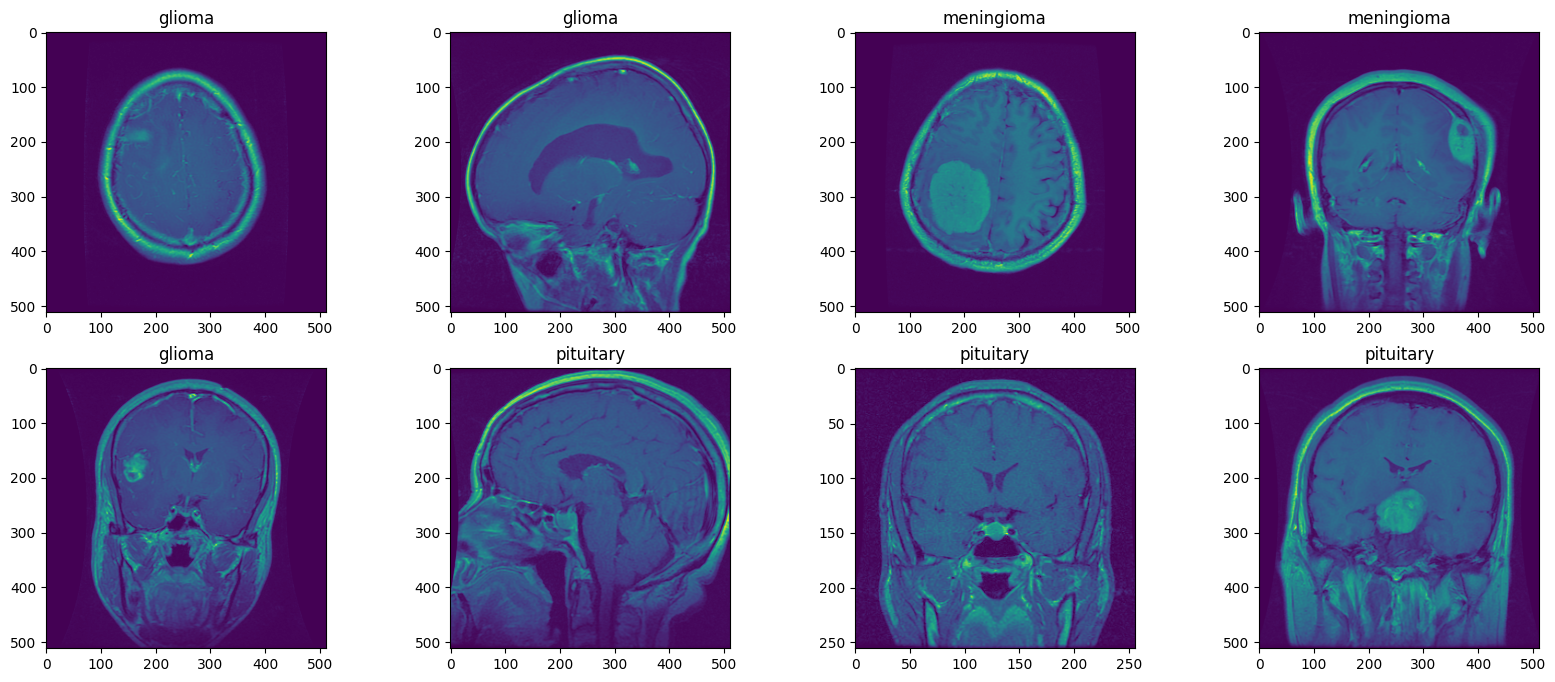

In [10]:
Brain_Tumor_obj = Brain_Tumor(15, 2, 'brain_tumor_dataset', tf.keras.optimizers.Adam(0.001), 'categorical_crossentropy')
Brain_Tumor_obj.plot_some_dataset_images(8)

In [11]:
Brain_Tumor_obj.collect_features_labels()

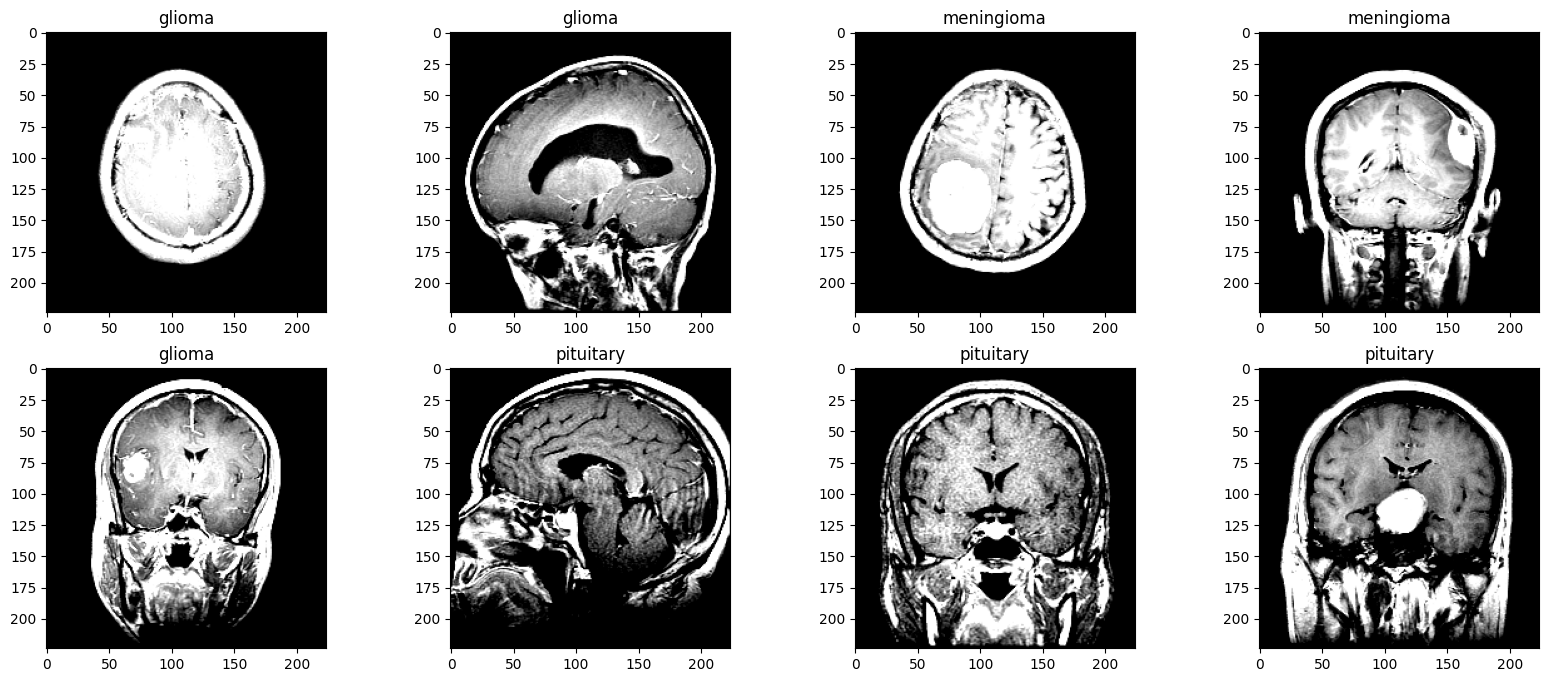

In [12]:
plt.figure(figsize = (20, 8))

for i in range(8):
  plt.subplot(2, 4, i+ 1)
  plt.imshow(Brain_Tumor_obj.images[i])
  plt.title(Brain_Tumor_obj.classes[Brain_Tumor_obj.labels[i] - 1])
plt.show()

In [13]:
Brain_Tumor_obj.augmentated_images()

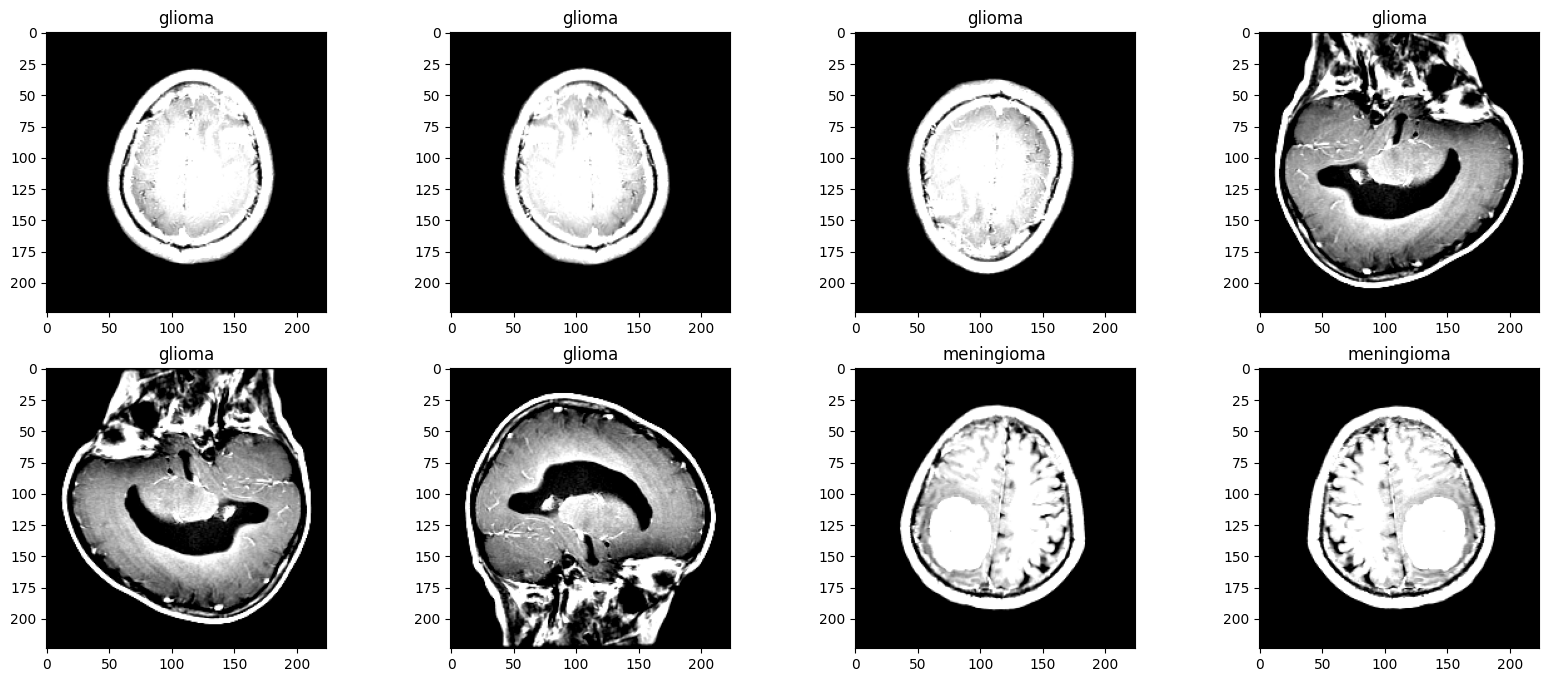

In [14]:
plt.figure(figsize = (20, 8))

for i in range(8):
  plt.subplot(2, 4, i + 1)
  plt.imshow(Brain_Tumor_obj.images[i])
  plt.title(Brain_Tumor_obj.classes[Brain_Tumor_obj.labels[i] - 1])
plt.show()

In [15]:
Brain_Tumor_obj.to_categorical_label()

In [16]:
Brain_Tumor_obj.train_test_split(0.1)

In [17]:
Brain_Tumor_obj.Model()
Brain_Tumor_obj.compile()
Brain_Tumor_obj.fit_model()

Epoch 1/15
4136/4136 ━━━━━━━━━━━━━━━━━━━━ 1061s 246ms/step - accuracy: 0.5113 - loss: 1.1447 - val_accuracy: 0.7054 - val_loss: 0.6483 - learning_rate: 0.0010
Epoch 2/15
4136/4136 ━━━━━━━━━━━━━━━━━━━━ 1025s 248ms/step - accuracy: 0.6906 - loss: 0.7376 - val_accuracy: 0.8870 - val_loss: 0.2989 - learning_rate: 0.0010
Epoch 3/15
4136/4136 ━━━━━━━━━━━━━━━━━━━━ 1029s 249ms/step - accuracy: 0.7792 - loss: 0.5657 - val_accuracy: 0.8837 - val_loss: 0.3018 - learning_rate: 0.0010
Epoch 4/15
4136/4136 ━━━━━━━━━━━━━━━━━━━━ 1027s 248ms/step - accuracy: 0.8378 - loss: 0.4226 - val_accuracy: 0.9130 - val_loss: 0.2183 - learning_rate: 0.0010
Epoch 5/15
4136/4136 ━━━━━━━━━━━━━━━━━━━━ 1046s 253ms/step - accuracy: 0.8780 - loss: 0.3201 - val_accuracy: 0.9304 - val_loss: 0.1923 - learning_rate: 0.0010
Epoch 6/15
4136/4136 ━━━━━━━━━━━━━━━━━━━━ 1029s 249ms/step - accuracy: 0.9019 - loss: 0.2803 - val_accuracy: 0.9315 - val_loss: 0.2036 - learning_rate: 0.0010
Epoch 7/15
4136/4136 ━━━━━━━━━━━━━━━━━━━━ 1026

In [18]:
Brain_Tumor_obj.m.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 16,602,699 (63.33 MB)

 Trainable params: 4,781,059 (18.24 MB)

 Non-trainable params: 2,259,520 (8.62 MB)

 Optimizer params: 9,562,120 (36.48 MB)

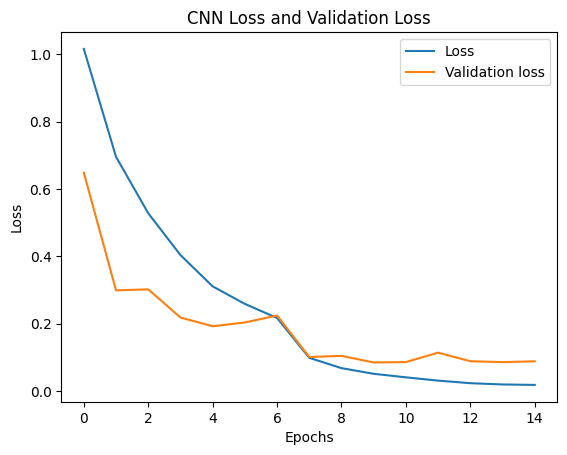

In [19]:
plt.plot(Brain_Tumor_obj.history.history['loss'], label = "Loss")
plt.plot(Brain_Tumor_obj.history.history['val_loss'], label = "Validation loss")
plt.title("CNN Loss and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

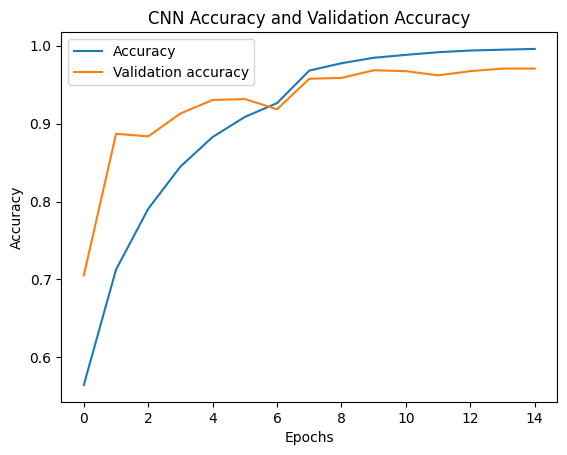

In [20]:
plt.plot(Brain_Tumor_obj.history.history['accuracy'], label = "Accuracy")
plt.plot(Brain_Tumor_obj.history.history['val_accuracy'], label = "Validation accuracy")
plt.title("CNN Accuracy and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [21]:
Brain_Tumor_obj.m.save("drive/MyDrive/brain_tumor_model.h5")
Brain_Tumor_obj.m.save_weights("drive/MyDrive/brain_tumor_weights.weights.h5")

In [22]:
Brain_Tumor_obj.m.evaluate(Brain_Tumor_obj.X_test, Brain_Tumor_obj.y_test, batch_size = 2)

460/460 ━━━━━━━━━━━━━━━━━━━━ 60s 130ms/step - accuracy: 0.9660 - loss: 0.0926


[0.08477382361888885, 0.968478262424469]

In [23]:
y_pred = Brain_Tumor_obj.m.predict(Brain_Tumor_obj.X_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step


In [24]:
y_pred = np.argmax(y_pred, axis = 1)

In [25]:
y_test = np.argmax(Brain_Tumor_obj.y_test, axis = 1)

In [26]:
accuracy_score(y_pred, y_test)

0.9684782608695652

Text(0.5, 1.0, 'CNN Confusion Matrix')

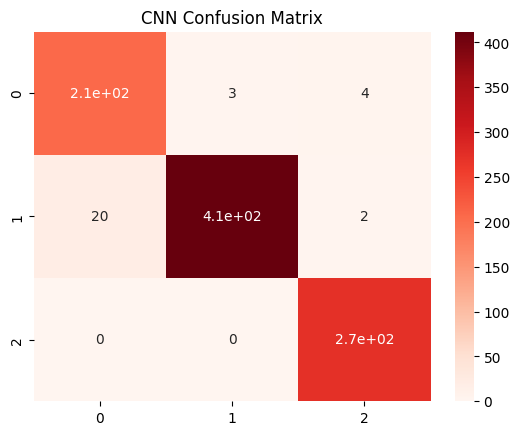

In [27]:
sn.heatmap(tf.math.confusion_matrix(
    y_test,
    y_pred,
), cmap=plt.cm.Reds, annot=True).set_title("CNN Confusion Matrix")

In [28]:
report = classification_report(y_test, y_pred, output_dict=True)

report_df = pd.DataFrame(report).transpose()

print(report_df)

              precision    recall  f1-score     support
0              0.911894  0.967290  0.938776  214.000000
1              0.992771  0.949309  0.970554  434.000000
2              0.978417  1.000000  0.989091  272.000000
accuracy       0.968478  0.968478  0.968478    0.968478
macro avg      0.961028  0.972199  0.966140  920.000000
weighted avg   0.969715  0.968478  0.968642  920.000000


In [29]:
mod = tf.keras.models.load_model("drive/MyDrive/brain_tumor_model.h5")
mod.load_weights("drive/MyDrive/brain_tumor_weights.weights.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 394 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [30]:
new_model = tf.keras.models.Model(
    mod.input,
    mod.get_layer('GlobalAveragePooling2D_').output
)

In [31]:
X_train_features = new_model.predict(Brain_Tumor_obj.X_train)

259/259 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step


In [32]:
X_train_features.shape

(8272, 1024)

In [33]:
param_dist_xgb = {
    'xgb__n_estimators': [700],
    'xgb__max_depth': [20],
    'xgb__learning_rate': [0.01, 0.1]
}

In [34]:
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBClassifier(objective='multi:softprob'))
])

random_search_xgb = RandomizedSearchCV(xgb_pipeline, param_dist_xgb, n_iter=50, refit=True, verbose=3, cv=5)

In [35]:
random_search_xgb.fit(X_train_features, np.argmax(Brain_Tumor_obj.y_train, axis=1))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=50. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END xgb__learning_rate=0.01, xgb__max_depth=20, xgb__n_estimators=700;, score=0.996 total time= 1.5min
[CV 2/5] END xgb__learning_rate=0.01, xgb__max_depth=20, xgb__n_estimators=700;, score=0.995 total time= 1.6min
[CV 3/5] END xgb__learning_rate=0.01, xgb__max_depth=20, xgb__n_estimators=700;, score=0.995 total time= 1.6min
[CV 4/5] END xgb__learning_rate=0.01, xgb__max_depth=20, xgb__n_estimators=700;, score=0.997 total time= 1.5min
[CV 5/5] END xgb__learning_rate=0.01, xgb__max_depth=20, xgb__n_estimators=700;, score=0.998 total time= 1.6min
[CV 1/5] END xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=700;, score=0.998 total time=  33.4s
[CV 2/5] END xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=700;, score=0.996 total time=  31.9s
[CV 3/5] END xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=700;, score=0.995 total time=  31.2s
[CV 4/5] END xgb__learning_rate=0.1, xgb__max_d

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            gamma=None,
                                                            grow_policy=None,
                                                            importance_t...
                                                            max_cat_to_onehot=None,
                                                            max_delta_step=None,
                                                            max_depth=None,
                                                            max_leaves=None,
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            objective='multi:softprob', ...))]),
                   n_iter=50,
                   param_distributions={'xgb__learning_rate': [0.01, 0.1],
                                        'xgb__max_depth': [20],
                                        'xgb__n_estimators': [700]},
                   verbose=3)

In [36]:
print(f"Best parameters found: {random_search_xgb.best_params_}")

Best parameters found: {'xgb__n_estimators': 700, 'xgb__max_depth': 20, 'xgb__learning_rate': 0.1}


In [37]:
best_xgb = random_search_xgb.best_estimator_

In [38]:
X_test_features = new_model.predict(Brain_Tumor_obj.X_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step


In [44]:
param_grid = {
    'svc__C': [100, 50],
    'svc__gamma': [0.01],
    'svc__kernel': ['rbf']
}

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True))
])

random_search = RandomizedSearchCV(svm_pipeline, param_grid, refit=True, n_iter=50, verbose=3, cv=5)

In [45]:
random_search.fit(X_train_features, np.argmax(Brain_Tumor_obj.y_train, axis=1))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=50. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/5] END svc__C=100, svc__gamma=0.01, svc__kernel=rbf;, score=0.993 total time=  44.5s
[CV 2/5] END svc__C=100, svc__gamma=0.01, svc__kernel=rbf;, score=0.989 total time=  42.9s
[CV 3/5] END svc__C=100, svc__gamma=0.01, svc__kernel=rbf;, score=0.987 total time=  43.7s
[CV 4/5] END svc__C=100, svc__gamma=0.01, svc__kernel=rbf;, score=0.989 total time=  43.2s
[CV 5/5] END svc__C=100, svc__gamma=0.01, svc__kernel=rbf;, score=0.982 total time=  40.9s
[CV 1/5] END svc__C=50, svc__gamma=0.01, svc__kernel=rbf;, score=0.993 total time=  42.5s
[CV 2/5] END svc__C=50, svc__gamma=0.01, svc__kernel=rbf;, score=0.989 total time=  41.6s
[CV 3/5] END svc__C=50, svc__gamma=0.01, svc__kernel=rbf;, score=0.987 total time=  42.1s
[CV 4/5] END svc__C=50, svc__gamma=0.01, svc__kernel=rbf;, score=0.989 total time=  43.5s
[CV 5/5] END svc__C=50, svc__gamma=0.01, svc__kernel=rbf;, score=0.982 total time=  41.7s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svc', SVC(probability=True))]),
                   n_iter=50,
                   param_distributions={'svc__C': [100, 50],
                                        'svc__gamma': [0.01],
                                        'svc__kernel': ['rbf']},
                   verbose=3)

In [46]:
print(f"Best parameters found: {random_search.best_params_}")

Best parameters found: {'svc__kernel': 'rbf', 'svc__gamma': 0.01, 'svc__C': 100}


In [47]:
best_svm = random_search.best_estimator_

In [48]:
y_pred = best_svm.predict(X_test_features)

In [49]:
y_test = np.argmax(Brain_Tumor_obj.y_test, axis =1)

In [53]:
base_models = [
    ('xgb', best_xgb),
    ('svm', best_svm)
]

In [54]:
meta_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [55]:
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

In [56]:
stacking_clf.fit(X_train_features, np.argmax(Brain_Tumor_obj.y_train, axis=1))

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('xgb',
                                                 XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               device=None,
                                                               early_stopping_rounds=None,
                                                               enable_categorical=False,
                                                               eval_metric=None,
                                                               feature_types=None,
                                                               gamma=None,
                                                               grow_policy=None,
                                                               imp...
                                                               max_depth=20,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=700,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               objective='multi:softprob', ...))])),
                               ('svm',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('svc',
                                                 SVC(C=100, gamma=0.01,
                                                     probability=True))]))],
                   final_estimator=LogisticRegression(multi_class='multinomial'))

In [59]:
accuracy_score(y_pred, y_test)

0.9836956521739131

Text(0.5, 1.0, 'Stacking Classifier Confusion Matrix')

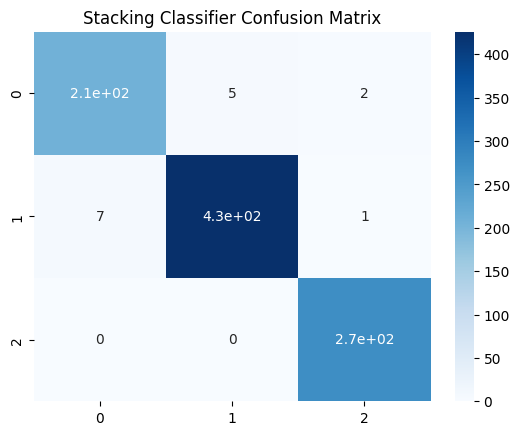

In [60]:
sn.heatmap(tf.math.confusion_matrix(
    y_test,
    y_pred,
), cmap=plt.cm.Blues, annot=True).set_title("Stacking Classifier Confusion Matrix")

In [61]:
report = classification_report(y_test, y_pred, output_dict=True)

report_df = pd.DataFrame(report).transpose()

print(report_df)

              precision    recall  f1-score     support
0              0.967290  0.967290  0.967290  214.000000
1              0.988399  0.981567  0.984971  434.000000
2              0.989091  1.000000  0.994516  272.000000
accuracy       0.983696  0.983696  0.983696    0.983696
macro avg      0.981593  0.982952  0.982259  920.000000
weighted avg   0.983693  0.983696  0.983680  920.000000
